In [1]:
# load libraries
options(stringsAsFactors = F)
suppressPackageStartupMessages({
library(Signac)
library(Seurat)
library(JASPAR2022)
library(TFBSTools)
library(BSgenome.Mmusculus.UCSC.mm10)
library(patchwork)
library(dplyr)
library(wordcloud2)
library(webshot)
library("htmlwidgets")
library(clusterProfiler)
library(org.Mm.eg.db)
library(stringr)
library(gtools)
library(ggrepel)
})
set.seed(123)

In [2]:
# load the sample
sample <- readRDS("sample_mouse_ATAC_TE.rds")

In [3]:
# Get a list of motif position frequency matrices from the JASPAR database
# pfm <- getMatrixSet(
#   x = JASPAR2020,
#   opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
# )
# load pre downloaded matrices in case of network error
pfm <- readRDS("meta/pfm_jaspar2022.rds")

In [4]:
# add motif information
main.chroms <- standardChromosomes(BSgenome.Mmusculus.UCSC.mm10)
keep.peaks <- which(as.character(seqnames(granges(sample))) %in% main.chroms)
suppressWarnings({
sample[["peaks"]] <- subset(sample[["peaks"]], features = rownames(sample[["peaks"]])[keep.peaks])

sample <- AddMotifs(
  object = sample,
  genome = BSgenome.Mmusculus.UCSC.mm10,
  pfm = pfm)
})
sample_all <- sample

Building motif matrix

Finding motif positions

Creating Motif object



In [5]:
# filter peaks with unusual chromosomes
main.chroms <- standardChromosomes(BSgenome.Mmusculus.UCSC.mm10)
keep.peaks <- which(as.character(seqnames(granges(sample))) %in% main.chroms)
sample[["peaks"]] <- subset(sample[["peaks"]], features = rownames(sample[["peaks"]])[keep.peaks])

In [6]:
# load TE GRanges
mm10_te_granges <- readRDS("./meta/mm10_te_granges.rds")

In [7]:
# extract peaks overlapping with TEs
suppressWarnings({
keep.peaks <- unique(queryHits(findOverlaps(granges(sample), mm10_te_granges)))
sample[["peaks"]] <- subset(sample[["peaks"]], features = rownames(sample[["peaks"]])[keep.peaks])
})

In [8]:
# find all differentially accessible peaks (overlapping with TEs)
# DefaultAssay(sample) <- 'peaks'
# Idents(sample) <- sample$celltype
# suppressWarnings({
# da_peaks_TEs_all <- FindAllMarkers(
#   object = sample,
#   min.pct = 0.05,
#   only.pos = T,
#   test.use = 'LR',
#   latent.vars = 'nCount_peaks')
# })

# write.csv(da_peaks_TEs_all, "meta/da_peaks_overlapping_with_TEs_all_mouse.csv")

In [9]:
# get top differentially accessible peaks overlapping with TEs
da_peaks_TEs_all <- read.csv("meta/da_peaks_all_siginificant_overlapping_TE.csv")
da_peaks_TEs_all <- na.omit(da_peaks_TEs_all)
top_da_peaks_TEs_vec <- unique(subset(da_peaks_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & celltype == "VEC")$peak_loc)
top_da_peaks_TEs_aec <- unique(subset(da_peaks_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & celltype == "AEC")$peak_loc)
top_da_peaks_TEs_prehec <- unique(subset(da_peaks_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & celltype == "pre-HEC")$peak_loc)
top_da_peaks_TEs_hsc <- unique(subset(da_peaks_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & celltype == "HEC/HSC")$peak_loc)

In [10]:
# plot wordcloud for celltype-specific TEPs (VEC)
da_TEs_vec <- subset(da_peaks_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & celltype == "VEC")$gene_name
da_TEs_family_vec <- unlist(strsplit(da_TEs_vec, split = ".", fixed = T))[seq(1, 3 * length(da_TEs_vec), by = 3)]
da_TEs_class_vec <- unlist(strsplit(da_TEs_vec, split = ".", fixed = T))[seq(3, 3 * length(da_TEs_vec), by = 3)]
da_TEs_family_vec <- as.data.frame(table(paste(da_TEs_family_vec, da_TEs_class_vec, sep = ".")))
word <- unlist(strsplit(as.character(da_TEs_family_vec$Var1), split = ".", fixed = T))[seq(1, 2 * nrow(da_TEs_family_vec), by = 2)]
class <- unlist(strsplit(as.character(da_TEs_family_vec$Var1), split = ".", fixed = T))[seq(2, 2 * nrow(da_TEs_family_vec), by = 2)]
da_TEs_family_wordcloud <- data.frame(word = word, freq = da_TEs_family_vec$Freq, class = class)
da_TEs_family_wordcloud <- da_TEs_family_wordcloud[order(da_TEs_family_wordcloud$class), ]
da_TEs_family_wordcloud <- da_TEs_family_wordcloud[da_TEs_family_wordcloud$class != "Other", ]
class_color_df <- data.frame(class = c("LINE","SINE","LTR","DNA"), color = c("#00AFBB", "#70AD47", "#E7B800", "#FC4E07"))
da_TEs_family_wordcloud <- merge(da_TEs_family_wordcloud, class_color_df)
da_TEs_family_wordcloud$class <- NULL
da_TEs_family_wordcloud <- da_TEs_family_wordcloud[order(da_TEs_family_wordcloud$freq, decreasing = T), ]
te_vec_wordcloud <- wordcloud2(data=da_TEs_family_wordcloud, size=1, color=da_TEs_family_wordcloud$color, shape = "triangle")
saveWidget(te_vec_wordcloud, "./figure/te_vec_wordcloud.html", selfcontained = F)
webshot("./figure/te_vec_wordcloud.html", "./figure/te_vec_wordcloud.pdf", delay = 5, vwidth = 1600, vheight = 900)

In [11]:
# plot wordcloud for celltype-specific TEPs (AEC)
da_TEs_aec <- subset(da_peaks_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & celltype == "AEC")$gene_name
da_TEs_family_aec <- unlist(strsplit(da_TEs_aec, split = ".", fixed = T))[seq(1, 3 * length(da_TEs_aec), by = 3)]
da_TEs_class_aec <- unlist(strsplit(da_TEs_aec, split = ".", fixed = T))[seq(3, 3 * length(da_TEs_aec), by = 3)]
da_TEs_family_aec <- as.data.frame(table(paste(da_TEs_family_aec, da_TEs_class_aec, sep = ".")))
word <- unlist(strsplit(as.character(da_TEs_family_aec$Var1), split = ".", fixed = T))[seq(1, 2 * nrow(da_TEs_family_aec), by = 2)]
class <- unlist(strsplit(as.character(da_TEs_family_aec$Var1), split = ".", fixed = T))[seq(2, 2 * nrow(da_TEs_family_aec), by = 2)]
da_TEs_family_wordcloud <- data.frame(word = word, freq = da_TEs_family_aec$Freq, class = class)
da_TEs_family_wordcloud <- da_TEs_family_wordcloud[order(da_TEs_family_wordcloud$class), ]
da_TEs_family_wordcloud <- da_TEs_family_wordcloud[da_TEs_family_wordcloud$class != "Other", ]
class_color_df <- data.frame(class = c("LINE","SINE","LTR","DNA"), color = c("#00AFBB", "#70AD47", "#E7B800", "#FC4E07"))
da_TEs_family_wordcloud <- merge(da_TEs_family_wordcloud, class_color_df)
da_TEs_family_wordcloud$class <- NULL
da_TEs_family_wordcloud <- da_TEs_family_wordcloud[order(da_TEs_family_wordcloud$freq, decreasing = T), ]
te_aec_wordcloud <- wordcloud2(data=da_TEs_family_wordcloud, size=1, color=da_TEs_family_wordcloud$color, shape = "triangle")
saveWidget(te_aec_wordcloud, "./figure/te_aec_wordcloud.html", selfcontained = F)
webshot("./figure/te_aec_wordcloud.html", "./figure/te_aec_wordcloud.pdf", delay = 5, vwidth = 1600, vheight = 900)

In [12]:
# plot wordcloud for celltype-specific TEPs (pre-HEC)
da_TEs_prehec <- subset(da_peaks_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & celltype == "pre-HEC")$gene_name
da_TEs_family_prehec <- unlist(strsplit(da_TEs_prehec, split = ".", fixed = T))[seq(1, 3 * length(da_TEs_prehec), by = 3)]
da_TEs_class_prehec <- unlist(strsplit(da_TEs_prehec, split = ".", fixed = T))[seq(3, 3 * length(da_TEs_prehec), by = 3)]
da_TEs_family_prehec <- as.data.frame(table(paste(da_TEs_family_prehec, da_TEs_class_prehec, sep = ".")))
word <- unlist(strsplit(as.character(da_TEs_family_prehec$Var1), split = ".", fixed = T))[seq(1, 2 * nrow(da_TEs_family_prehec), by = 2)]
class <- unlist(strsplit(as.character(da_TEs_family_prehec$Var1), split = ".", fixed = T))[seq(2, 2 * nrow(da_TEs_family_prehec), by = 2)]
da_TEs_family_wordcloud <- data.frame(word = word, freq = da_TEs_family_prehec$Freq, class = class)
da_TEs_family_wordcloud <- da_TEs_family_wordcloud[order(da_TEs_family_wordcloud$class), ]
da_TEs_family_wordcloud <- da_TEs_family_wordcloud[da_TEs_family_wordcloud$class != "Other", ]
class_color_df <- data.frame(class = c("LINE","SINE","LTR","DNA"), color = c("#00AFBB", "#70AD47", "#E7B800", "#FC4E07"))
da_TEs_family_wordcloud <- merge(da_TEs_family_wordcloud, class_color_df)
da_TEs_family_wordcloud$class <- NULL
da_TEs_family_wordcloud <- da_TEs_family_wordcloud[order(da_TEs_family_wordcloud$freq, decreasing = T), ]
te_prehec_wordcloud <- wordcloud2(data=da_TEs_family_wordcloud, size=1, color=da_TEs_family_wordcloud$color, shape = "triangle")
saveWidget(te_prehec_wordcloud, "./figure/te_prehec_wordcloud.html", selfcontained = F)
webshot("./figure/te_prehec_wordcloud.html", "./figure/te_prehec_wordcloud.pdf", delay = 5, vwidth = 1600, vheight = 900)

In [13]:
# plot wordcloud for celltype-specific TEPs (HEC/HSC)
da_TEs_hsc <- subset(da_peaks_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & celltype == "HEC/HSC")$gene_name
da_TEs_family_hsc <- unlist(strsplit(da_TEs_hsc, split = ".", fixed = T))[seq(1, 3 * length(da_TEs_hsc), by = 3)]
da_TEs_class_hsc <- unlist(strsplit(da_TEs_hsc, split = ".", fixed = T))[seq(3, 3 * length(da_TEs_hsc), by = 3)]
da_TEs_family_hsc <- as.data.frame(table(paste(da_TEs_family_hsc, da_TEs_class_hsc, sep = ".")))
word <- unlist(strsplit(as.character(da_TEs_family_hsc$Var1), split = ".", fixed = T))[seq(1, 2 * nrow(da_TEs_family_hsc), by = 2)]
class <- unlist(strsplit(as.character(da_TEs_family_hsc$Var1), split = ".", fixed = T))[seq(2, 2 * nrow(da_TEs_family_hsc), by = 2)]
da_TEs_family_wordcloud <- data.frame(word = word, freq = da_TEs_family_hsc$Freq, class = class)
da_TEs_family_wordcloud <- da_TEs_family_wordcloud[order(da_TEs_family_wordcloud$class), ]
da_TEs_family_wordcloud <- da_TEs_family_wordcloud[da_TEs_family_wordcloud$class != "Other", ]
class_color_df <- data.frame(class = c("LINE","SINE","LTR","DNA"), color = c("#00AFBB", "#70AD47", "#E7B800", "#FC4E07"))
da_TEs_family_wordcloud <- merge(da_TEs_family_wordcloud, class_color_df)
da_TEs_family_wordcloud$class <- NULL
da_TEs_family_wordcloud <- da_TEs_family_wordcloud[order(da_TEs_family_wordcloud$freq, decreasing = T), ]
te_hsc_wordcloud <- wordcloud2(data=da_TEs_family_wordcloud, size=1, color=da_TEs_family_wordcloud$color, shape = "triangle")
saveWidget(te_hsc_wordcloud, "./figure/te_hsc_wordcloud.html", selfcontained = F)
webshot("./figure/te_hsc_wordcloud.html", "./figure/te_hsc_wordcloud.pdf", delay = 5, vwidth = 1600, vheight = 900)

In [14]:
# get top differentially accessible peaks
# da_peaks_TEs_all <- read.csv("da_peaks_overlapping_with_TEs_all_mouse.csv", row.names = 1)
# top_da_peaks_TEs_vec <- subset(da_peaks_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & cluster == "VEC")$gene
# top_da_peaks_TEs_aec <- subset(da_peaks_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & cluster == "AEC")$gene
# top_da_peaks_TEs_prehec <- subset(da_peaks_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & cluster == "pre-HEC")$gene
# top_da_peaks_TEs_hsc <- subset(da_peaks_TEs_all, p_val_adj <= 0.05 & avg_log2FC >= 0.5 & cluster == "HEC/HSC")$gene

In [15]:
# find motifs
DefaultAssay(sample) <- "peaks"
enriched_motifs_vec <- FindMotifs(object = sample, features = top_da_peaks_TEs_vec)
enriched_motifs_vec$celltype <- "VEC"
enriched_motifs_aec <- FindMotifs(object = sample, features = top_da_peaks_TEs_aec)
enriched_motifs_aec$celltype <- "AEC"
enriched_motifs_prehec <- FindMotifs(object = sample, features = top_da_peaks_TEs_prehec)
enriched_motifs_prehec$celltype <- "pre-HEC"
enriched_motifs_hsc <- FindMotifs(object = sample, features = top_da_peaks_TEs_hsc)
enriched_motifs_hsc$celltype <- "HEC/HSC"

enriched_motifs_all <- rbind(enriched_motifs_vec, enriched_motifs_aec, enriched_motifs_prehec, enriched_motifs_hsc)
write.csv(enriched_motifs_all, "meta/enriched_motifs_TEs_overlapping_peaks_mouse.csv")

Selecting background regions to match input sequence characteristics

Matching GC.percent distribution

Testing motif enrichment in 788 regions

Selecting background regions to match input sequence characteristics

Matching GC.percent distribution

Testing motif enrichment in 136 regions

Selecting background regions to match input sequence characteristics

Matching GC.percent distribution

Testing motif enrichment in 402 regions

Selecting background regions to match input sequence characteristics

Matching GC.percent distribution

Testing motif enrichment in 359 regions



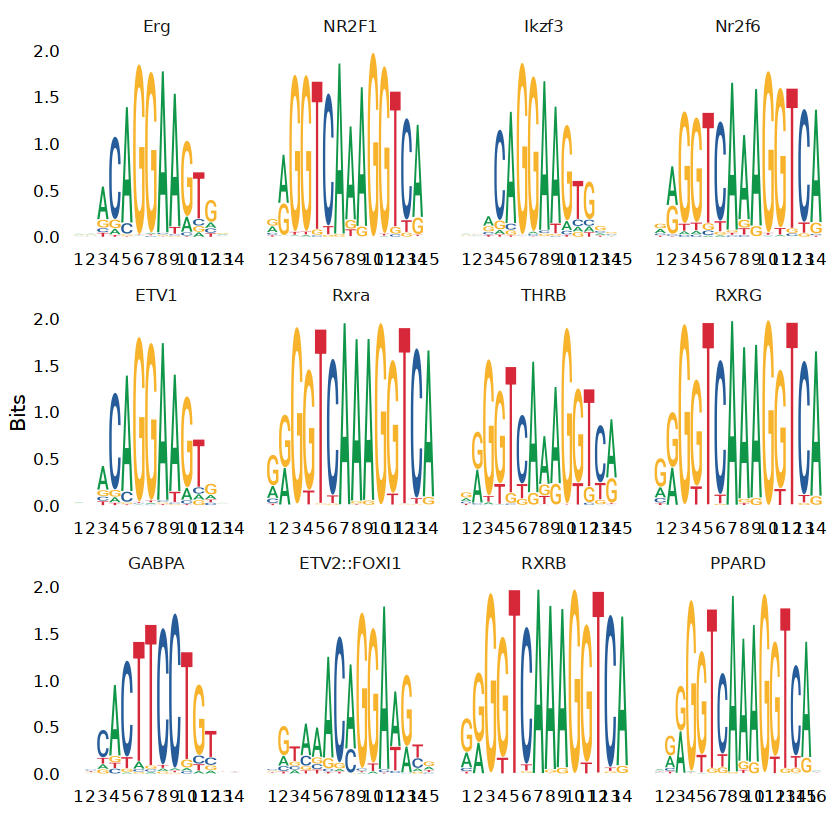

In [20]:
# plot motifs VEC
MotifPlot(object = sample, motifs =rownames(enriched_motifs_vec)[c(1:6, 8:13)])

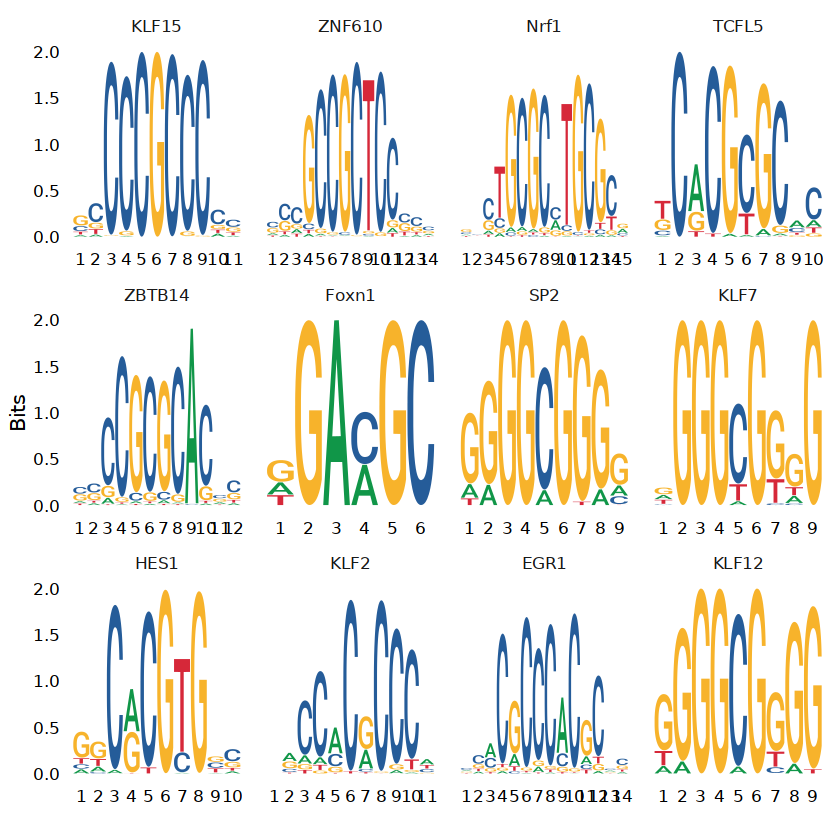

In [21]:
# plot motifs AEC
MotifPlot(object = sample, motifs = head(rownames(enriched_motifs_aec), 12))

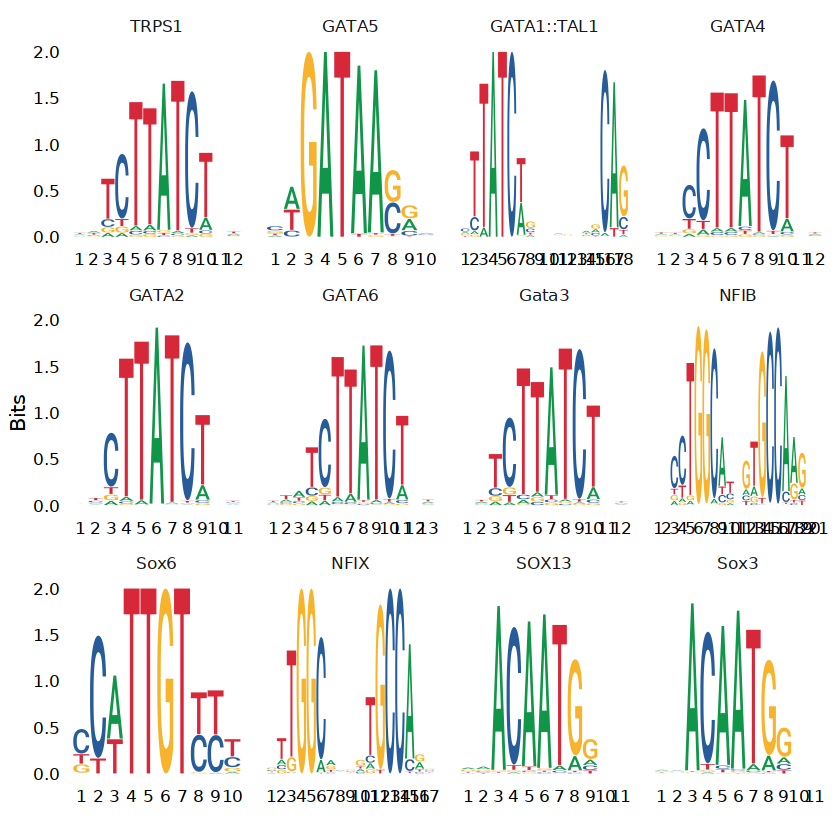

In [22]:
# plot motifs pre-HEC
MotifPlot(object = sample, motifs = head(rownames(enriched_motifs_prehec), 12))

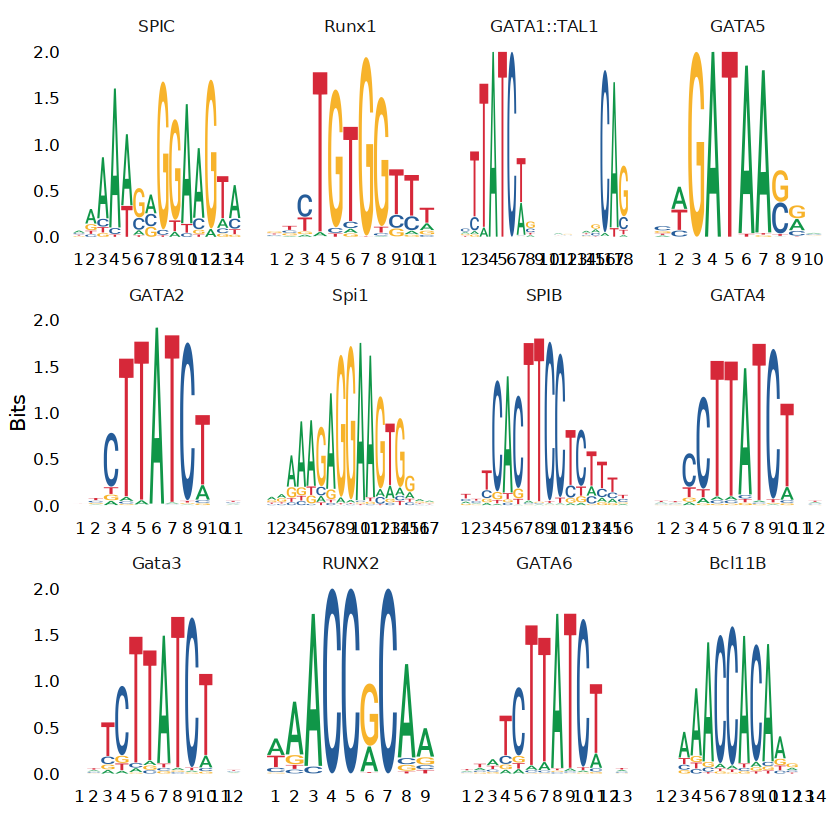

In [23]:
# plot motifs HEC/HSC
MotifPlot(object = sample, motifs = head(rownames(enriched_motifs_hsc), 12))

In [24]:
# computing motif activities
suppressWarnings(sample <- RunChromVAR(object = sample, genome = BSgenome.Mmusculus.UCSC.mm10))

Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay



In [25]:
# save the sample with motif activities
saveRDS(sample, file = "sample_mouse_ATAC_motif.rds")

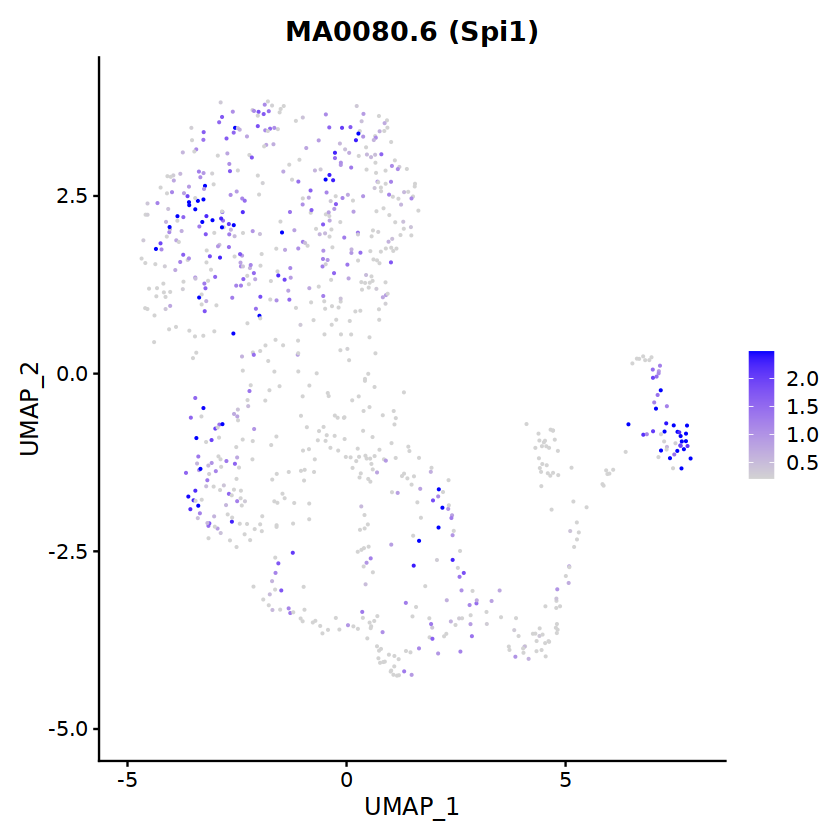

In [26]:
# plot the motif activity (Spi1)
DefaultAssay(sample) <- 'chromvar'
FeaturePlot(object = sample, features = "MA0080.6", min.cutoff = 'q10', max.cutoff = 'q90', pt.size = 0.1) + ggtitle("MA0080.6 (Spi1)")

In [27]:
# load the RNA sample
sample_rna <- readRDS("../1_EHT_RNA_Preprocessing/sample_mouse_annotated.rds")
sample_rna$celltype <- as.character(sample_rna$celltype)
sample_rna$celltype[sample_rna$celltype == "HEC"] <- "HEC/HSC"
sample_rna$celltype[sample_rna$celltype == "HSC"] <- "HEC/HSC"
sample_rna$celltype <- factor(sample_rna$celltype, levels = c("VEC","AEC","pre-HEC","HEC/HSC"))

Selecting background regions to match input sequence characteristics

Matching GC.percent distribution

Testing motif enrichment in 3 regions

Warning message in FindMotifs(object = sample_all, features = c(e1, e2, p1), assay = "peaks"):
“Testing motif enrichment using a small number of regions is not recommended”
Warning message in FetchData.Seurat(object = object, vars = features, cells = cells):
“The following requested variables were not found: Znf263”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


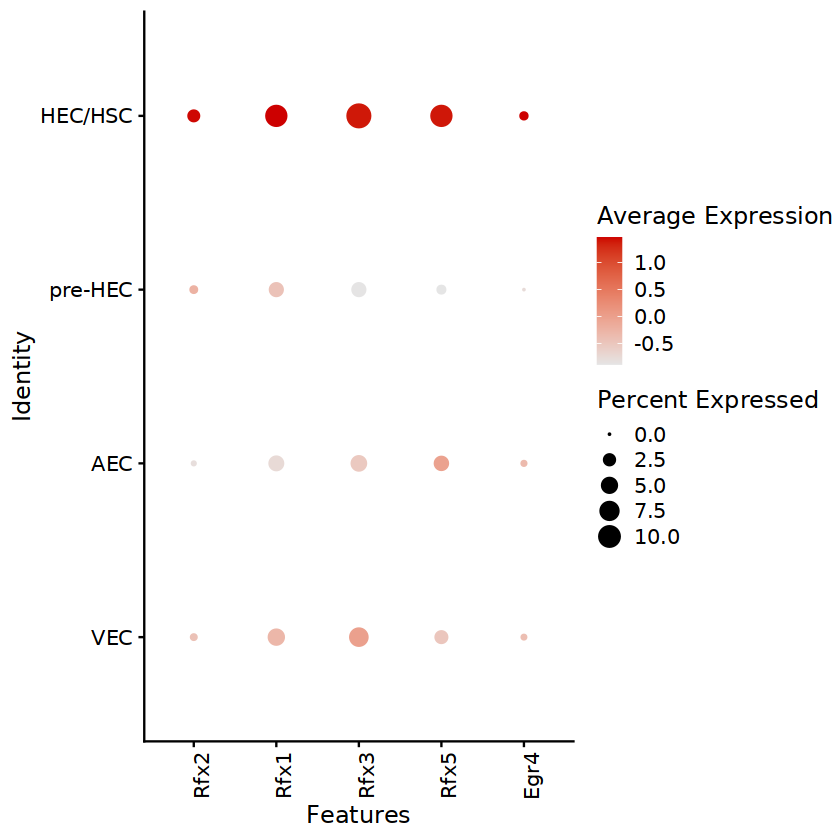

In [28]:
# Gja5 involved motifs
e1 <- "chr3-96953528-96954458"
e2 <- "chr3-96937264-96938092"
p1 <- "chr3-97031798-97032697"
gja5_motifs <- FindMotifs(object = sample_all, features = c(e1, e2, p1), assay = "peaks")
DotPlot(sample_rna, features = str_to_title(tolower(head(gja5_motifs$motif.name))), assay = "SCT", group.by = "celltype", cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))

In [29]:
# calculate celltype markers
Idents(sample_rna) <- sample_rna$celltype
celltype_marker_genes <- FindAllMarkers(sample_rna, assay = "RNA", test.use = "MAST", min.pct = 0.05, only.pos = TRUE, verbose = FALSE)


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



In [30]:
# plot significant motifs in VEC
enriched_motifs_vec_significant <- subset(enriched_motifs_vec, p.adjust <= 0.05)
enriched_motifs_vec_significant <- enriched_motifs_vec_significant[!duplicated(enriched_motifs_vec_significant$motif.name), "motif"]
p <- MotifPlot(object = sample, motifs = enriched_motifs_vec_significant, ncol = 1, assay = "peaks")
png("figure/enrichment_motifs_vec_significant_mouse.png", width = 300, height = 12000)
print(p)
dev.off()

png 
  2

In [31]:
# plot motif activities for motifs in VEC
count_motifs_vec <- sample@assays$chromvar@data[enriched_motifs_vec_significant, ]
rownames(count_motifs_vec) <- paste(enriched_motifs_vec_significant, " (", str_to_title(tolower(enriched_motifs_vec[enriched_motifs_vec_significant, "motif.name"])), ")", sep = "")
sample_vec <- CreateSeuratObject(count_motifs_vec, meta.data = sample@meta.data)
p <- DotPlot(sample_vec, features = rev(rownames(sample_vec)), group.by = "celltype", cols=c("grey90", "purple3"), scale.by = "size") + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust=1))
png("figure/enrichment_motif_activity_vec_mouse.png", width = 600, height = 4000)
print(p)
dev.off()

Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

In [32]:
# plot TF expression for motifs in VEC
enriched_motifs_vec_significant <- subset(enriched_motifs_vec, p.adjust <= 0.05)
enriched_TFs_vec_significant <- unlist(str_to_title(tolower(unlist(strsplit(enriched_motifs_vec_significant$motif.name, split = "::")))))
p <- DotPlot(sample_rna, features = rev(intersect(enriched_TFs_vec_significant, rownames(sample_rna))), assay = "SCT", group.by = "celltype", cols=c("grey90","red3"), scale.by = "size") + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust=1))
png("figure/enrichment_TF_expression_vec_mouse.png", width = 600, height = 3000)
print(p)
dev.off()

Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

Warning message:
“Scaling data with a low number of groups may produce misleading results”


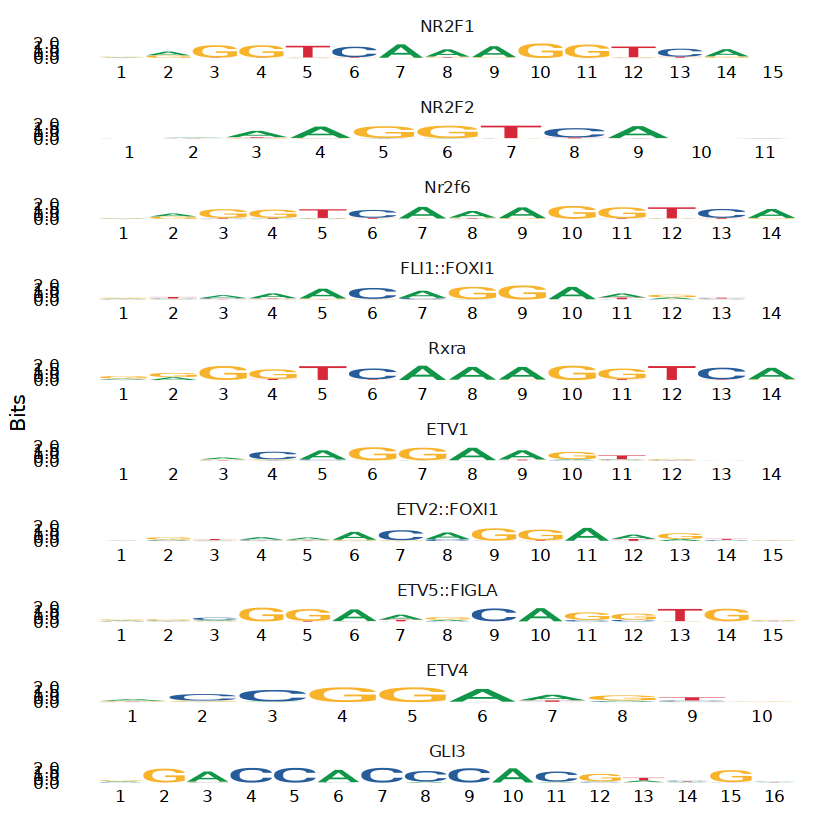

Warning message:
“Scaling data with a low number of groups may produce misleading results”


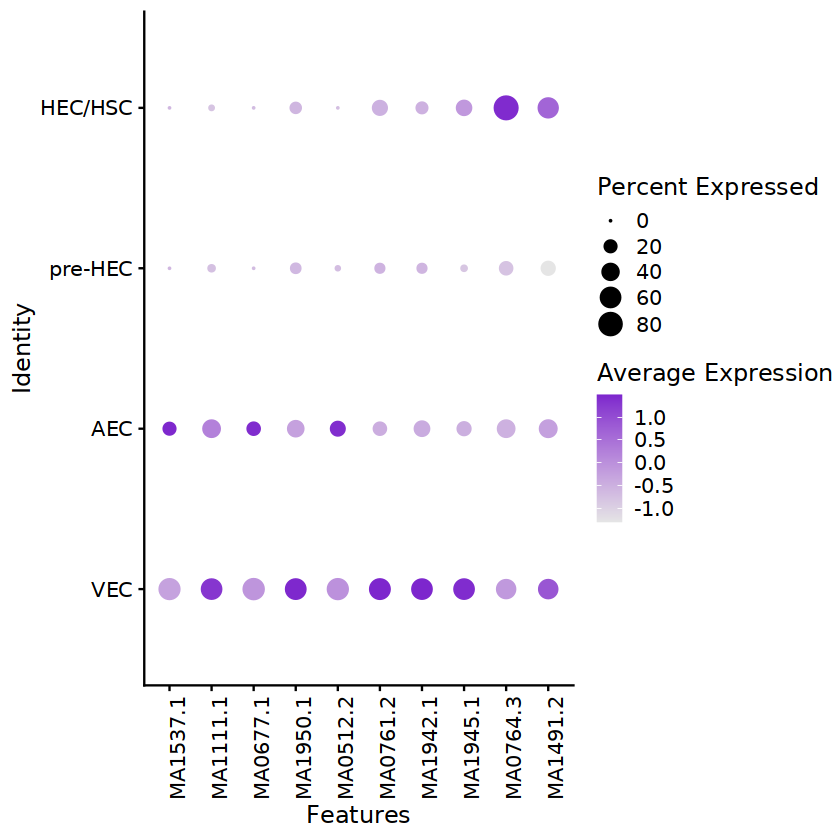

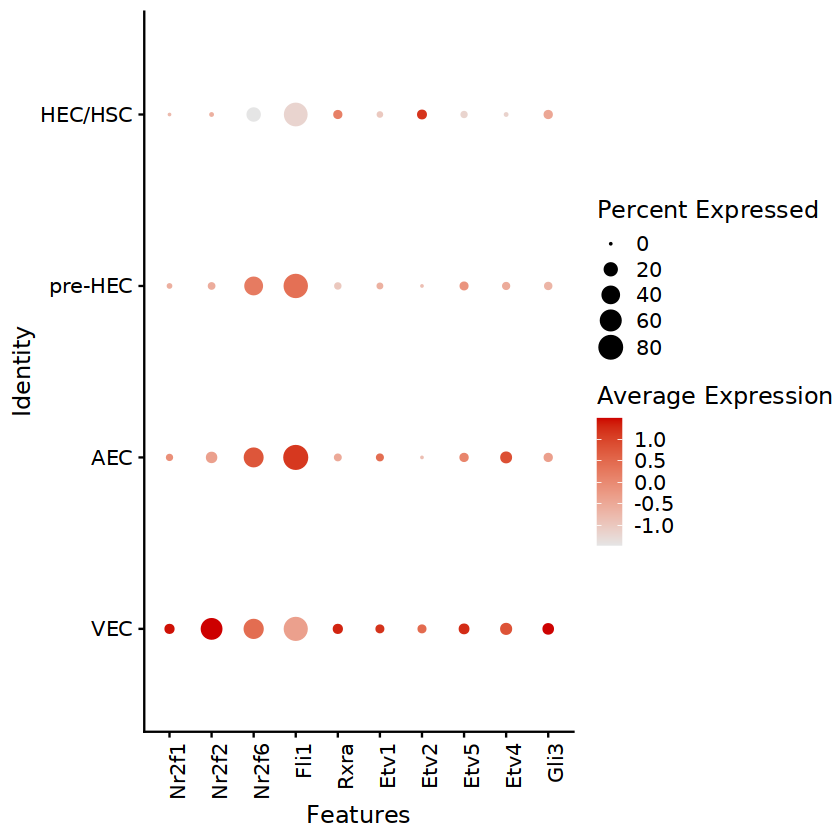

In [33]:
# select TFs in VEC
enriched_motifs_vec_selected <- c("MA1537.1","MA1111.1","MA0677.1","MA1950.1","MA0512.2","MA0761.2","MA1942.1","MA1945.1","MA0764.3","MA1491.2")
enriched_TFs_vec_selected <- c("Nr2f1","Nr2f2","Nr2f6","Fli1","Rxra","Etv1","Etv2","Etv5","Etv4","Gli3")
MotifPlot(object = sample, motifs = enriched_motifs_vec_selected, ncol = 1, assay = "peaks")
ggsave("figure/enriched_motifs_vec_selected.pdf", width = 3, height = 10)
DotPlot(sample, features = enriched_motifs_vec_selected, assay = "chromvar", group.by = "celltype", cols=c("grey90","purple3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/dotplot_enriched_motifs_vec.pdf", width = 6, height = 2.4)
DotPlot(sample_rna, features = enriched_TFs_vec_selected, assay = "SCT", group.by = "celltype", cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/dotplot_enriched_TFs_vec.pdf", width = 6, height = 2)

In [34]:
# plot significant motifs in AEC
enriched_motifs_aec_significant <- subset(enriched_motifs_aec, p.adjust <= 0.05)
enriched_motifs_aec_significant <- enriched_motifs_aec_significant[!duplicated(enriched_motifs_aec_significant$motif.name), "motif"]
p <- MotifPlot(object = sample, motifs = enriched_motifs_aec_significant, ncol = 1, assay = "peaks")
png("figure/enrichment_motifs_aec_significant_mouse.png", width = 300, height = 3200)
print(p)
dev.off()

png 
  2

In [35]:
# plot motif activities for motifs in AEC
count_motifs_aec <- sample@assays$chromvar@data[enriched_motifs_aec_significant, ]
rownames(count_motifs_aec) <- paste(enriched_motifs_aec_significant, " (", str_to_title(tolower(enriched_motifs_aec[enriched_motifs_aec_significant, "motif.name"])), ")", sep = "")
sample_aec <- CreateSeuratObject(count_motifs_aec, meta.data = sample@meta.data)
p <- DotPlot(sample_aec, features = rev(rownames(sample_aec)), assay = "RNA", group.by = "celltype", cols=c("grey90","purple3"), scale.by = "size") + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust=1))
png("figure/enrichment_motif_activity_aec_mouse.png", width = 600, height = 1000)
print(p)
dev.off()

Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

In [36]:
# plot TF expression for motifs in AEC
enriched_motifs_aec_significant <- subset(enriched_motifs_aec, p.adjust <= 0.05)
enriched_TFs_aec_significant <- unlist(str_to_title(tolower(unlist(strsplit(enriched_motifs_aec_significant$motif.name, split = "::")))))
p <- DotPlot(sample_rna, features = rev(intersect(enriched_TFs_aec_significant, rownames(sample_rna))), assay = "SCT", group.by = "celltype", cols=c("grey90","red3"), scale.by = "size") + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust=1))
png("figure/enrichment_TF_expression_aec_mouse.png", width = 600, height = 800)
print(p)
dev.off()

Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

Warning message:
“Scaling data with a low number of groups may produce misleading results”


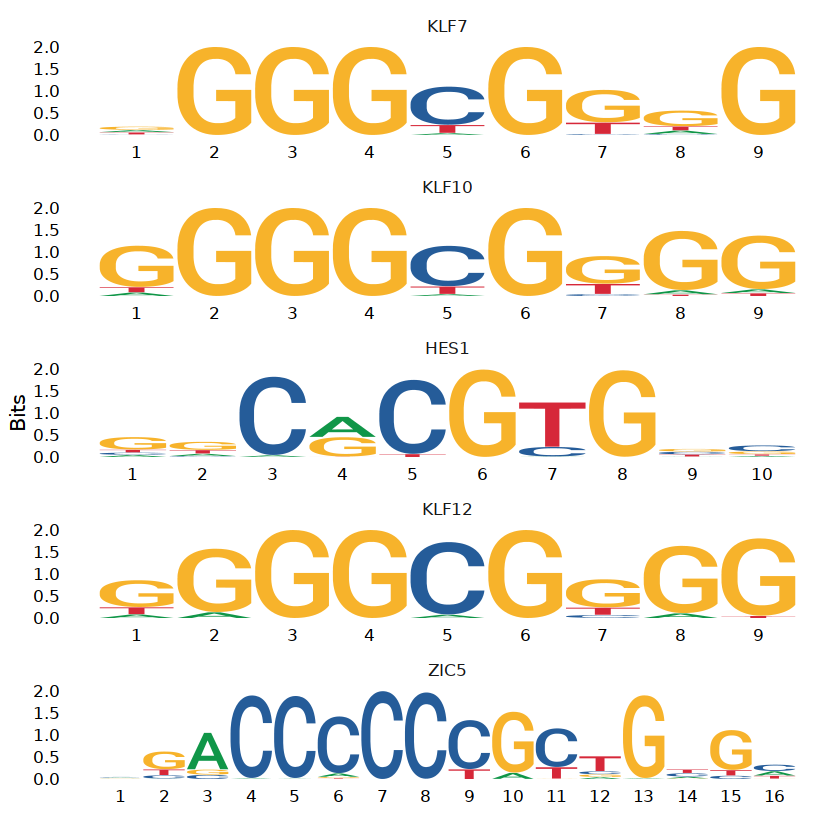

Warning message:
“Scaling data with a low number of groups may produce misleading results”


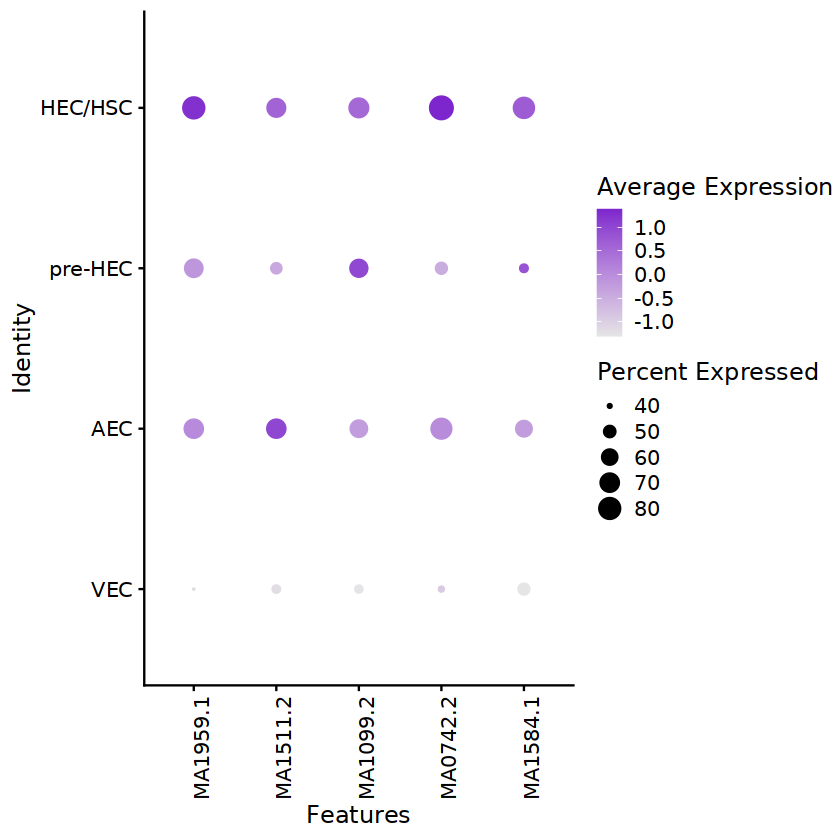

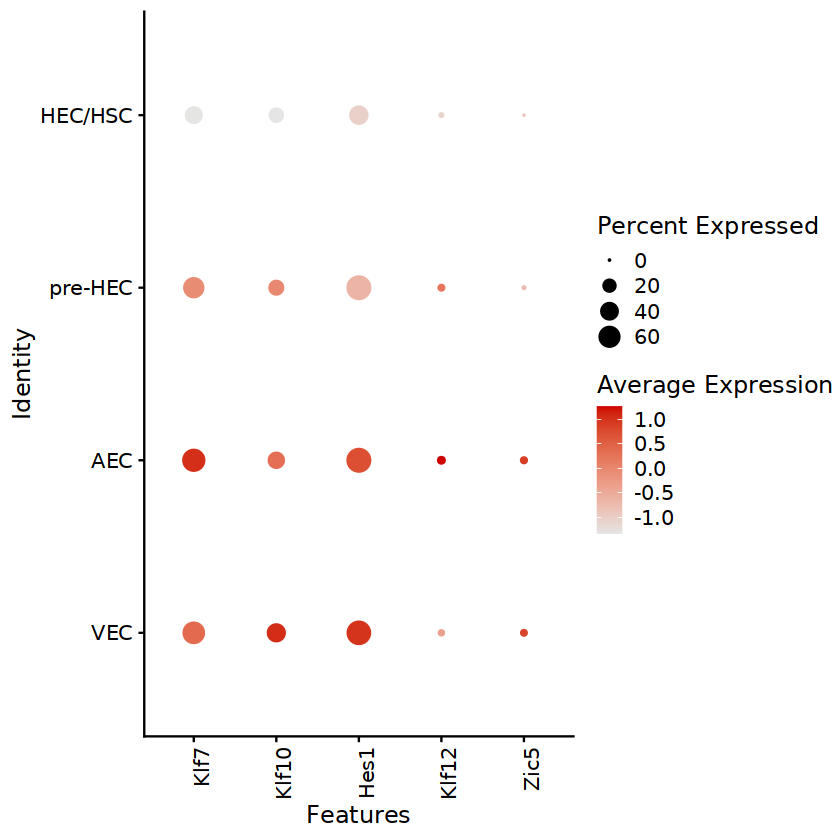

In [37]:
# select TFs in AEC
enriched_motifs_aec_selected <- c("MA1959.1","MA1511.2","MA1099.2","MA0742.2","MA1584.1")
enriched_TFs_aec_selected <- c("Klf7","Klf10","Hes1","Klf12","Zic5")
MotifPlot(object = sample, motifs = enriched_motifs_aec_selected, ncol = 1, assay = "peaks")
ggsave("figure/enriched_motifs_aec_selected.pdf", width = 3, height = 5)
DotPlot(sample, features = enriched_motifs_aec_selected, assay = "chromvar", group.by = "celltype", cols=c("grey90","purple3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/dotplot_enriched_motifs_aec.pdf", width = 4.5, height = 2.4)
DotPlot(sample_rna, features = enriched_TFs_aec_selected, assay = "SCT", group.by = "celltype", cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/dotplot_enriched_TFs_aec.pdf", width = 4.5, height = 2)

In [38]:
# plot significant motifs in pre-HEC
enriched_motifs_prehec_significant <- subset(enriched_motifs_prehec, p.adjust <= 0.05)
enriched_motifs_prehec_significant <- enriched_motifs_prehec_significant[!duplicated(enriched_motifs_prehec_significant$motif.name), "motif"]
p <- MotifPlot(object = sample, motifs = enriched_motifs_prehec_significant, ncol = 1, assay = "peaks")
png("figure/enrichment_motifs_prehec_significant_mouse.png", width = 300, height = 4000)
print(p)
dev.off()

png 
  2

In [39]:
# plot motif activities for motifs in pre-HEC
count_motifs_prehec <- sample@assays$chromvar@data[enriched_motifs_prehec_significant, ]
rownames(count_motifs_prehec) <- paste(enriched_motifs_prehec_significant, " (", str_to_title(tolower(enriched_motifs_prehec[enriched_motifs_prehec_significant, "motif.name"])), ")", sep = "")
sample_prehec <- CreateSeuratObject(count_motifs_prehec, meta.data = sample@meta.data)
p <- DotPlot(sample_prehec, features = rev(rownames(sample_prehec)), assay = "RNA", group.by = "celltype", cols=c("grey90","purple3"), scale.by = "size") + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust=1))
png("figure/enrichment_motif_activity_prehec_mouse.png", width = 600, height = 1400)
print(p)
dev.off()

Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

In [40]:
# plot TF expression for motifs in pre-HEC
enriched_motifs_prehec_significant <- subset(enriched_motifs_prehec, p.adjust <= 0.05)
enriched_TFs_prehec_significant <- unlist(str_to_title(tolower(unlist(strsplit(enriched_motifs_prehec_significant$motif.name, split = "::")))))
p <- DotPlot(sample_rna, features = rev(intersect(enriched_TFs_prehec_significant, rownames(sample_rna))), assay = "SCT", group.by = "celltype", cols=c("grey90","red3"), scale.by = "size") + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust=1))
png("figure/enrichment_TF_expression_prehec_mouse.png", width = 600, height = 1100)
print(p)
dev.off()

Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

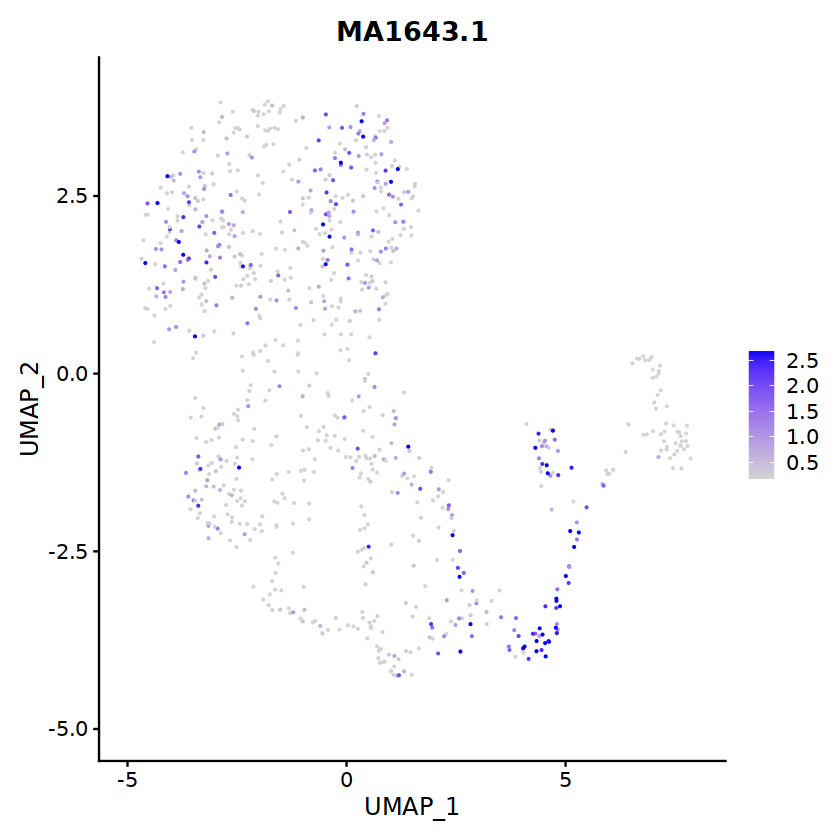

In [42]:
# plot the motif activity (Nfib)
DefaultAssay(sample) <- 'chromvar'
FeaturePlot(object = sample, features = "MA1643.1", min.cutoff = 'q10', max.cutoff = 'q90', pt.size = 0.1)

Warning message:
“Scaling data with a low number of groups may produce misleading results”


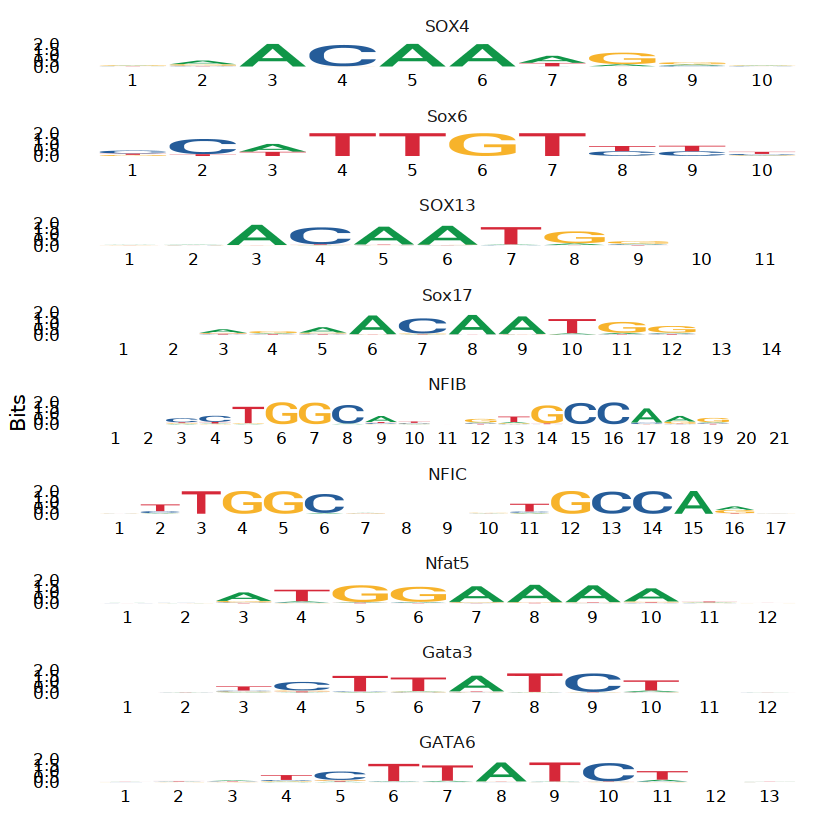

Warning message:
“Scaling data with a low number of groups may produce misleading results”


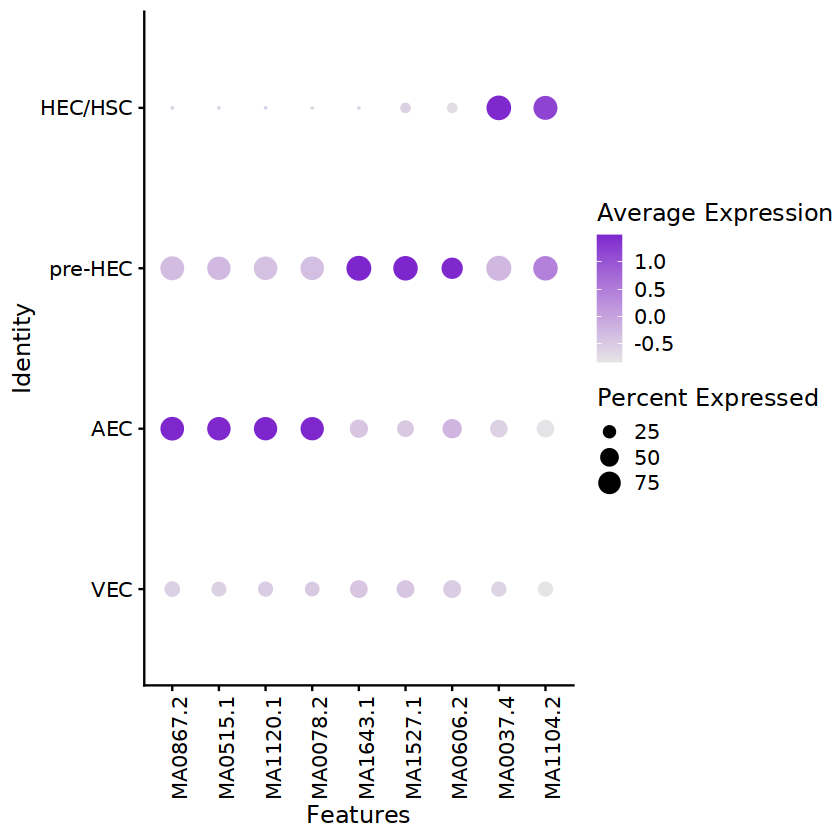

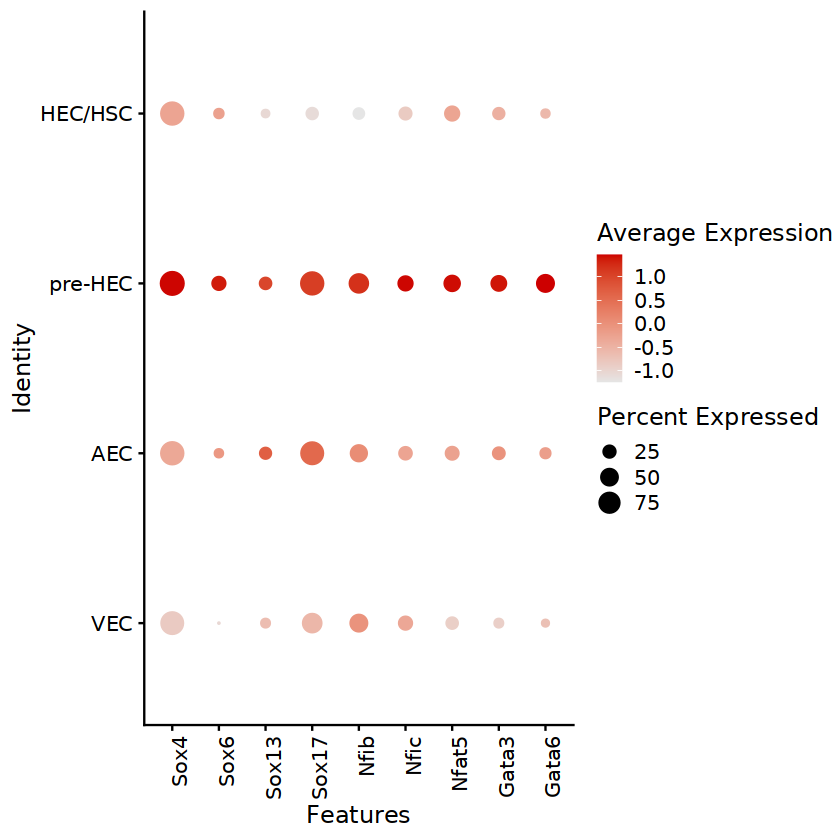

In [43]:
# select TFs in pre-HEC
enriched_motifs_prehec_selected <- c("MA0867.2","MA0515.1","MA1120.1","MA0078.2","MA1643.1","MA1527.1","MA0606.2","MA0037.4","MA1104.2")
enriched_TFs_prehec_selected <- c("Sox4","Sox6","Sox13","Sox17","Nfib","Nfic","Nfat5","Gata3","Gata6")
MotifPlot(object = sample, motifs = enriched_motifs_prehec_selected, ncol = 1, assay = "peaks")
ggsave("figure/enriched_motifs_prehec_selected.pdf", width = 3, height = 9)
DotPlot(sample, features = enriched_motifs_prehec_selected, assay = "chromvar", group.by = "celltype", cols=c("grey90","purple3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/dotplot_enriched_motifs_prehec.pdf", width = 6, height = 2.4)
DotPlot(sample_rna, features = enriched_TFs_prehec_selected, assay = "SCT", group.by = "celltype", cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/dotplot_enriched_TFs_prehec.pdf", width = 6, height = 2)

In [44]:
# plot significant motifs in HEC/HSC
enriched_motifs_hsc_significant <- subset(enriched_motifs_hsc, p.adjust <= 0.05)
enriched_motifs_hsc_significant <- enriched_motifs_hsc_significant[!duplicated(enriched_motifs_hsc_significant$motif.name), "motif"]
p <- MotifPlot(object = sample, motifs = enriched_motifs_hsc_significant, ncol = 1, assay = "peaks")
png("figure/enrichment_motifs_hsc_significant_mouse.png", width = 300, height = 1800)
print(p)
dev.off()

png 
  2

In [45]:
# plot motif activities for motifs in HEC/HSC
count_motifs_hsc <- sample@assays$chromvar@data[enriched_motifs_hsc_significant, ]
rownames(count_motifs_hsc) <- paste(enriched_motifs_hsc_significant, " (", str_to_title(tolower(enriched_motifs_hsc[enriched_motifs_hsc_significant, "motif.name"])), ")", sep = "")
sample_hsc <- CreateSeuratObject(count_motifs_hsc, meta.data = sample@meta.data)
p <- DotPlot(sample_hsc, features = rev(rownames(sample_hsc)), assay = "RNA", group.by = "celltype", cols=c("grey90","purple3"), scale.by = "size") + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust=1))
png("figure/enrichment_motif_activity_hsc_mouse.png", width = 600, height = 700)
print(p)
dev.off()

Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

In [46]:
# plot TF expression for motifs in HEC/HSC
enriched_motifs_hsc_significant <- subset(enriched_motifs_hsc, p.adjust <= 0.05)
enriched_TFs_hsc_significant <- unlist(str_to_title(tolower(unlist(strsplit(enriched_motifs_hsc_significant$motif.name, split = "::")))))
p <- DotPlot(sample_rna, features = rev(intersect(enriched_TFs_hsc_significant, rownames(sample_rna))), assay = "SCT", group.by = "celltype", cols=c("grey90","red3"), scale.by = "size") + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust=1))
png("figure/enrichment_TF_expression_hsc_mouse.png", width = 600, height = 500)
print(p)
dev.off()

Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

Warning message:
“Scaling data with a low number of groups may produce misleading results”


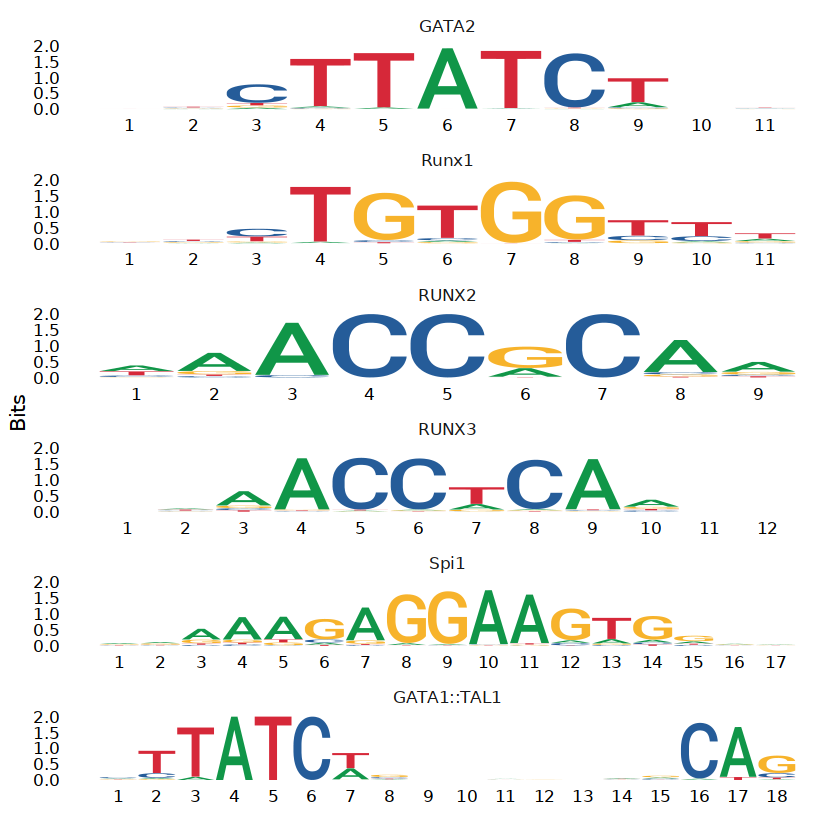

Warning message:
“Scaling data with a low number of groups may produce misleading results”


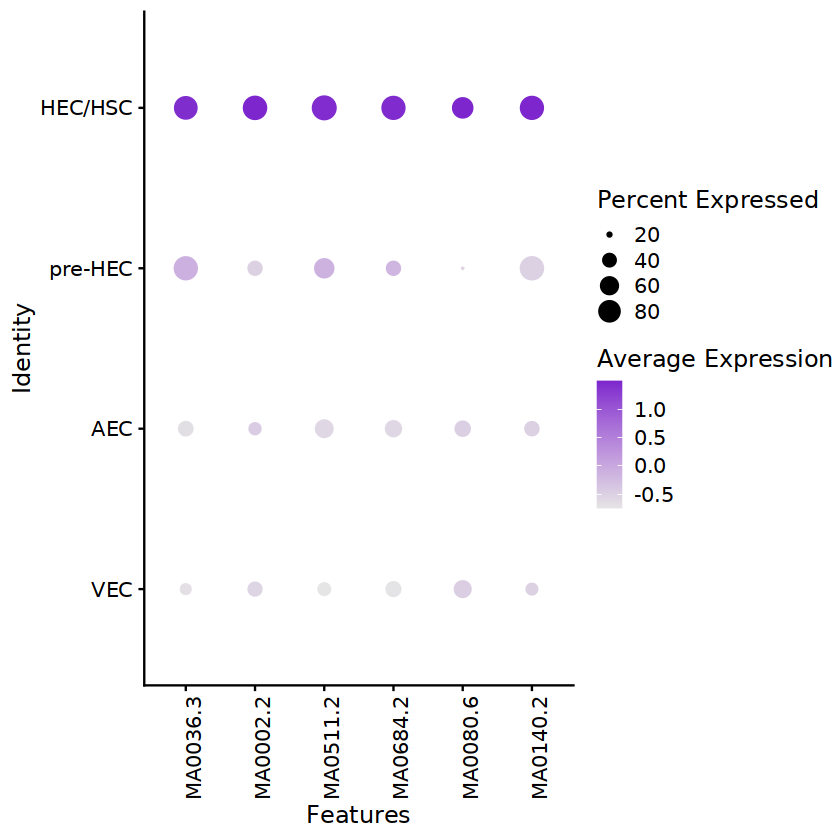

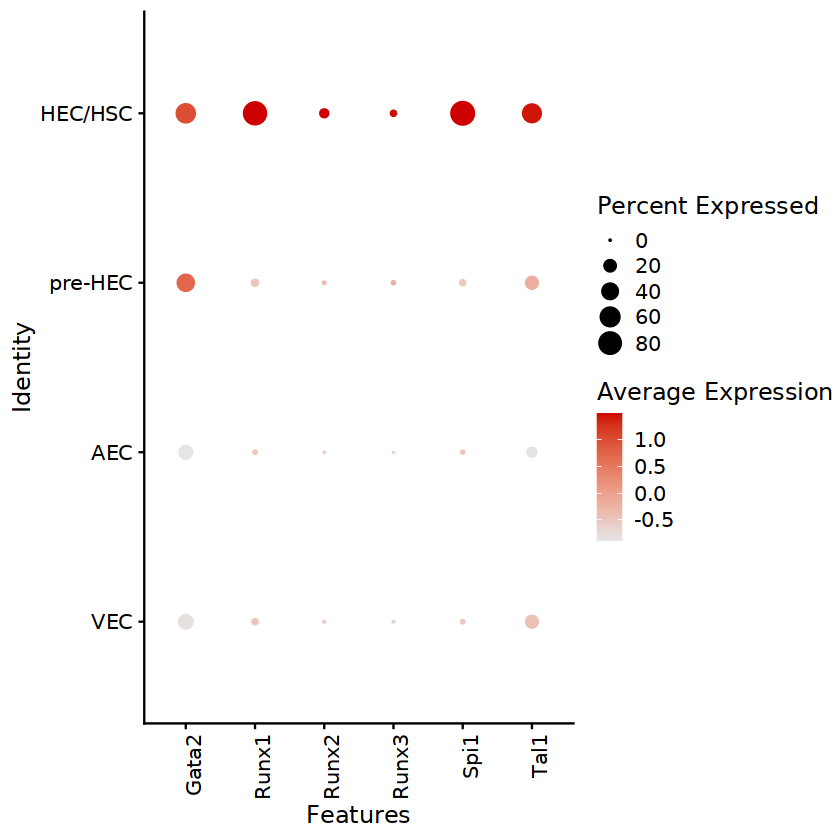

In [47]:
# select TFs in HEC/HSC
enriched_motifs_hsc_selected <- c("MA0036.3","MA0002.2","MA0511.2","MA0684.2","MA0080.6","MA0140.2")
enriched_TFs_hsc_selected <- c("Gata2","Runx1","Runx2","Runx3","Spi1","Tal1")
MotifPlot(object = sample, motifs = enriched_motifs_hsc_selected, ncol = 1, assay = "peaks")
ggsave("figure/enriched_motifs_hsc_selected.pdf", width = 3, height = 9)
DotPlot(sample, features = enriched_motifs_hsc_selected, assay = "chromvar", group.by = "celltype", cols=c("grey90","purple3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/dotplot_enriched_motifs_hsc.pdf", width = 5, height = 2.4)
DotPlot(sample_rna, features = enriched_TFs_hsc_selected, assay = "SCT", group.by = "celltype", cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/dotplot_enriched_TFs_hsc.pdf", width = 5, height = 2)

Warning message:
“Scaling data with a low number of groups may produce misleading results”


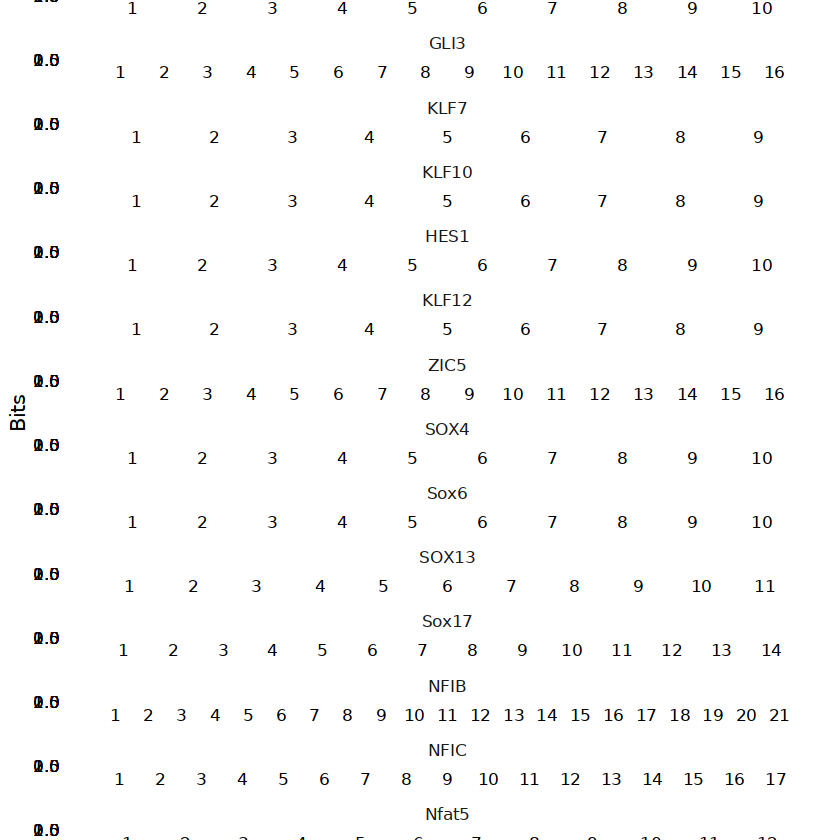

Warning message:
“Scaling data with a low number of groups may produce misleading results”


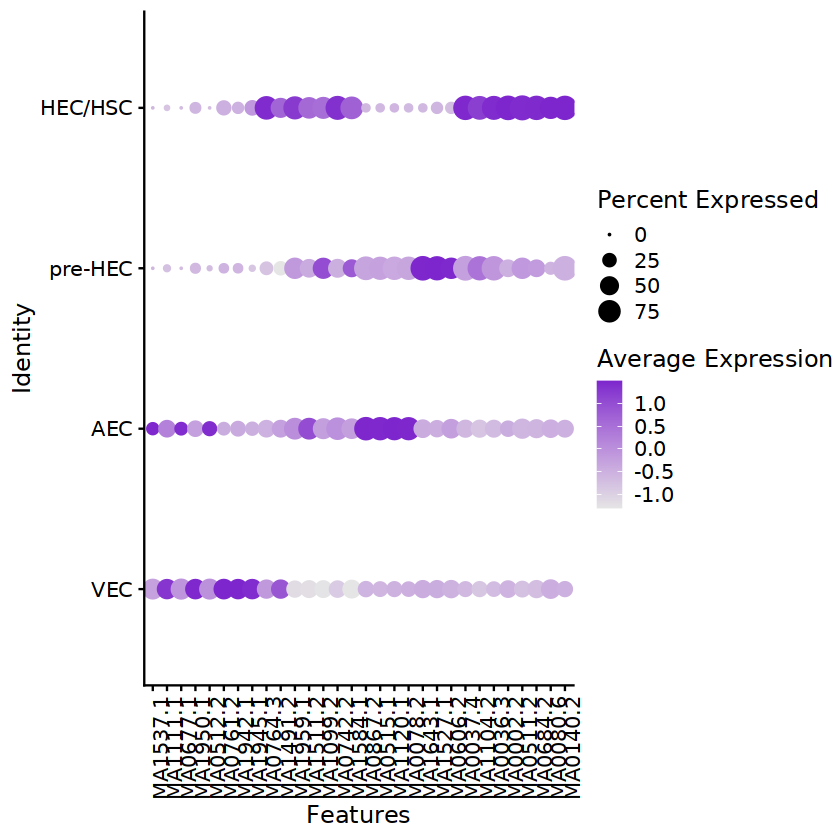

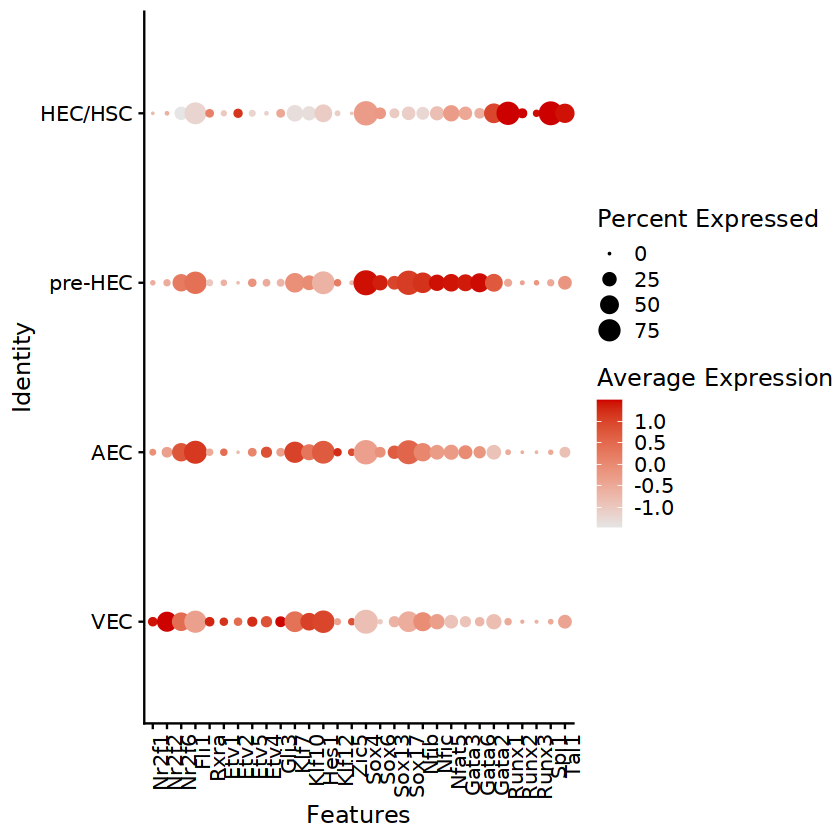

In [48]:
# select TFs and plot for all celltype
enriched_motifs_selected <- c(enriched_motifs_vec_selected, enriched_motifs_aec_selected, enriched_motifs_prehec_selected, enriched_motifs_hsc_selected)
enriched_TFs_selected <- c(enriched_TFs_vec_selected, enriched_TFs_aec_selected, enriched_TFs_prehec_selected, enriched_TFs_hsc_selected)
MotifPlot(object = sample, motifs = enriched_motifs_selected, ncol = 1, assay = "peaks")
ggsave("figure/enriched_motifs_selected.pdf", width = 3, height = 30)
DotPlot(sample, features = enriched_motifs_selected, assay = "chromvar", group.by = "celltype", cols=c("grey90","purple3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/dotplot_enriched_motifs.pdf", width = 10, height = 2.4)
DotPlot(sample_rna, features = enriched_TFs_selected, assay = "SCT", group.by = "celltype", cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/dotplot_enriched_TFs.pdf", width = 10, height = 2)

In [49]:
# read in tf-target sets (from TRRUST)
tf_target <- read.table("./meta/trrust_rawdata.mouse.tsv", header = F, sep = "\t", check.names = F)
tf_target <- unique(tf_target[, 1:2])

colnames(tf_target) <- c("TF","Target")

In [50]:
# construct TF-Target network in VECs
enriched_TFs_vec_significant_exp <- as.data.frame(AverageExpression(sample_rna, features = unique(enriched_TFs_vec_significant), assays = "SCT")$SCT)
enriched_TFs_vec_significant_selected <- rownames(enriched_TFs_vec_significant_exp[enriched_TFs_vec_significant_exp$VEC >= 0.25, ])
enriched_TFs_vec_significant_selected <- unique(c(enriched_TFs_vec_significant_selected, enriched_TFs_vec_selected))

tf_target_vec <- unique(tf_target[tf_target$TF %in% enriched_TFs_vec_significant_selected, "Target"])
tf_target_vec <- intersect(tf_target_vec, rownames(sample_rna))
p <- DotPlot(sample_rna, scale = T, features = tf_target_vec, assay = "SCT", group.by = "celltype", cols=c("grey90","red3"), scale.by = "size") + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust=1))
png("figure/TF_Target_expression_vec_mouse.png", width = 600, height = 3000)
print(p)
dev.off()

tf_target_vec_exp <- as.data.frame(AverageExpression(sample_rna, features = tf_target_vec, assays = "SCT")$SCT)
tf_target_vec_selected <- rownames(tf_target_vec_exp[tf_target_vec_exp$VEC >= 0.25, ])

tf_target_vec_network <- subset(tf_target, TF %in% enriched_TFs_vec_significant_selected & Target %in% tf_target_vec_selected)
tf_target_vec_network$celltype <- "VEC"

Warning message:
“The following 43 features were not found in the SCT assay: Ikzf3, Foxi1, Ehf, Nr1h4, Figla, Ppara, Tfap2c, Znf768, Elf5, Ebf2, Znf816, Etv7, Spib, Znf454, Znf331, Tfap2b, Neurod2, Tfap2e, Olig2, Znf669, Hoxb13, Ewsr1-Fli1, Nhlh1, Myf5, Ptf1a, Esr2, Neurod1, Znf320, Znf416, Bhlha15, Pax3, Atoh1, Znf530, Drgx, Znf341, Nr1i2, Znf528, Znf549, Znf263, Ferd3l, Znf682, Znf135, Znf281”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

In [51]:
# construct TF-Target network in AECs
enriched_TFs_aec_significant_exp <- as.data.frame(AverageExpression(sample_rna, features = unique(enriched_TFs_aec_significant), assays = "SCT")$SCT)
enriched_TFs_aec_significant_selected <- rownames(enriched_TFs_aec_significant_exp[enriched_TFs_aec_significant_exp$AEC >= 0.25, ])
enriched_TFs_aec_significant_selected <- unique(c(enriched_TFs_aec_significant_selected, enriched_TFs_aec_selected))

tf_target_aec <- unique(tf_target[tf_target$TF %in% enriched_TFs_aec_significant_selected, "Target"])
tf_target_aec <- intersect(tf_target_aec, rownames(sample_rna))
p <- DotPlot(sample_rna, scale = T, features = tf_target_aec, assay = "SCT", group.by = "celltype", cols=c("grey90","red3"), scale.by = "size") + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust=1))
png("figure/TF_Target_expression_aec_mouse.png", width = 600, height = 3000)
print(p)
dev.off()

tf_target_aec_exp <- as.data.frame(AverageExpression(sample_rna, features = tf_target_aec, assays = "SCT")$SCT)
tf_target_aec_selected <- rownames(tf_target_aec_exp[tf_target_aec_exp$AEC >= 0.25, ])

tf_target_aec_network <- subset(tf_target, TF %in% enriched_TFs_aec_significant_selected & Target %in% tf_target_aec_selected)
tf_target_aec_network$celltype <- "AEC"

Warning message:
“The following 9 features were not found in the SCT assay: Znf610, Foxn1, Sp9, Znf93, Znf148, Znf417, Znf530, Znf320, Znf454”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

In [52]:
# construct TF-Target network in pre-HECs
enriched_TFs_prehec_significant_exp <- as.data.frame(AverageExpression(sample_rna, features = unique(enriched_TFs_prehec_significant), assays = "SCT")$SCT)
enriched_TFs_prehec_significant_selected <- rownames(enriched_TFs_prehec_significant_exp[enriched_TFs_prehec_significant_exp$`pre-HEC` >= 0.25, ])
enriched_TFs_prehec_significant_selected <- unique(c(enriched_TFs_prehec_significant_selected, enriched_TFs_prehec_selected))

tf_target_prehec <- unique(tf_target[tf_target$TF %in% enriched_TFs_prehec_significant_selected, "Target"])
tf_target_prehec <- intersect(tf_target_prehec, rownames(sample_rna))
p <- DotPlot(sample_rna, scale = T, features = tf_target_prehec, assay = "SCT", group.by = "celltype", cols=c("grey90","red3"), scale.by = "size") + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust=1))
png("figure/TF_Target_expression_prehec_mouse.png", width = 600, height = 3000)
print(p)
dev.off()

tf_target_prehec_exp <- as.data.frame(AverageExpression(sample_rna, features = tf_target_prehec, assays = "SCT")$SCT)
tf_target_prehec_selected <- rownames(tf_target_prehec_exp[tf_target_prehec_exp$`pre-HEC` >= 0.25, ])

tf_target_prehec_network <- subset(tf_target, TF %in% enriched_TFs_prehec_significant_selected & Target %in% tf_target_prehec_selected)
tf_target_prehec_network$celltype <- "pre-HEC"

Warning message:
“The following 7 features were not found in the SCT assay: Sox3, Znf24, Sox14, Sry, Foxi1, Foxo6, Foxp3”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

In [53]:
# construct TF-Target network in HECs/HSCs
enriched_TFs_hsc_significant_exp <- as.data.frame(AverageExpression(sample_rna, features = unique(enriched_TFs_hsc_significant), assays = "SCT")$SCT)
enriched_TFs_hsc_significant_selected <- rownames(enriched_TFs_hsc_significant_exp[enriched_TFs_hsc_significant_exp$`HEC/HSC` >= 0.25, ])
enriched_TFs_hsc_significant_selected <- unique(c(enriched_TFs_hsc_significant_selected, enriched_TFs_hsc_selected))

tf_target_hsc <- unique(tf_target[tf_target$TF %in% enriched_TFs_hsc_significant_selected, "Target"])
tf_target_hsc <- intersect(tf_target_hsc, rownames(sample_rna))
p <- DotPlot(sample_rna, scale = T, features = tf_target_hsc, assay = "SCT", group.by = "celltype", cols=c("grey90","red3"), scale.by = "size") + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust=1))
png("figure/TF_Target_expression_hsc_mouse.png", width = 600, height = 3000)
print(p)
dev.off()

tf_target_hsc_exp <- as.data.frame(AverageExpression(sample_rna, features = tf_target_hsc, assays = "SCT")$SCT)
tf_target_hsc_selected <- rownames(tf_target_hsc_exp[tf_target_hsc_exp$`HEC/HSC` >= 0.25, ])

tf_target_hsc_network <- subset(tf_target, TF %in% enriched_TFs_hsc_significant_selected & Target %in% tf_target_hsc_selected)
tf_target_hsc_network$celltype <- "HEC/HSC"

Warning message:
“The following 6 features were not found in the SCT assay: Spic, Spib, Ehf, Etv7, Elf5, Znf816”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

In [56]:
# output the combined network data
tf_target_network <- rbind(tf_target_vec_network,tf_target_aec_network,tf_target_prehec_network,tf_target_hsc_network)
write.csv(tf_target_network, "meta/tf_target_network.csv")

In [57]:
# output the node feature
tf_target_network_source <- data.frame(TF = c(enriched_TFs_vec_significant_selected,enriched_TFs_aec_significant_selected,enriched_TFs_prehec_significant_selected,enriched_TFs_hsc_significant_selected), type = c(rep("VEC_TF", length(enriched_TFs_vec_significant_selected)),rep("AEC_TF",length(enriched_TFs_aec_significant_selected)),rep("pre-HEC_TF",length(enriched_TFs_prehec_significant_selected)),rep("HEC/HSC_TF",length(enriched_TFs_hsc_significant_selected))))
write.csv(tf_target_network_source, "meta/tf_target_network_source.csv")
tf_target_network_target <- data.frame(TF = c(tf_target_vec_selected,tf_target_aec_selected,tf_target_prehec_selected,tf_target_hsc_selected), type = c(rep("VEC_Target", length(tf_target_vec_selected)),rep("AEC_Target",length(tf_target_aec_selected)),rep("pre-HEC_Target",length(tf_target_prehec_selected)),rep("HEC/HSC_Target",length(tf_target_hsc_selected))))
write.csv(tf_target_network_target, "meta/tf_target_network_target.csv")

In [58]:
# plot TF expression
p <- DotPlot(sample_rna, scale = T, features = rev(unique(tf_target_network$TF)), assay = "SCT", group.by = "celltype", cols=c("grey90","red3"), scale.by = "size") + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust=1))
png("figure/TF_Target_expression_TF_mouse.png", width = 400, height = 1100)
print(p)
dev.off()

Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

In [59]:
# plot Target expression
p <- DotPlot(sample_rna, scale = T, features = rev(unique(tf_target_network$Target)), assay = "SCT", group.by = "celltype", cols=c("grey90","red3"), scale.by = "size") + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust=1))
png("figure/TF_Target_expression_Target_mouse.png", width = 400, height = 3500)
print(p)
dev.off()

Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

In [60]:
# GO enrichment
gene <- unique(c(enriched_TFs_vec_significant_selected, tf_target_vec_selected))
ego_vec <- enrichGO(gene   = gene,
              OrgDb        = org.Mm.eg.db,
              keyType      = "SYMBOL",
              ont          = "BP",
              pAdjustMethod = "BH",
              pvalueCutoff    = 0.01,
              qvalueCutoff    = 0.05,
              readable = TRUE)

In [61]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /root/miniconda3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggrepel_0.9.3                      ggplot2_3.4.2                     
 [3] gtools_3.9.4                       stringr_1.5.0                     
 [5] org.Mm.eg.db_3.16.0                AnnotationDbi_1.60.2              
 [7] Biobase_2.58.0                     clusterProfiler_4.6.2             
 [9] htmlwidgets_1.6.2                  webshot_0.5.4                     
[11] wordcloud2_0.2.1       